Appareil pour les opérations torch : cuda


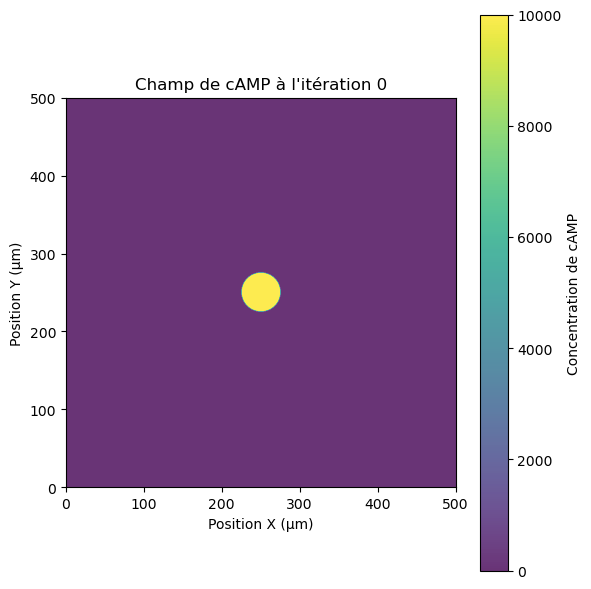

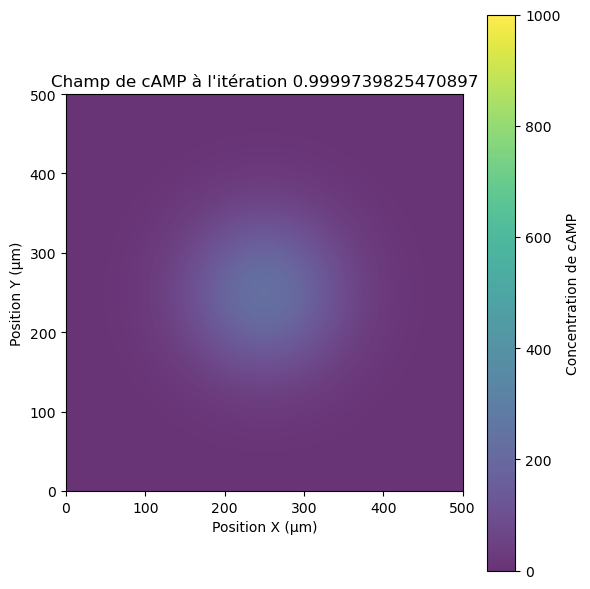

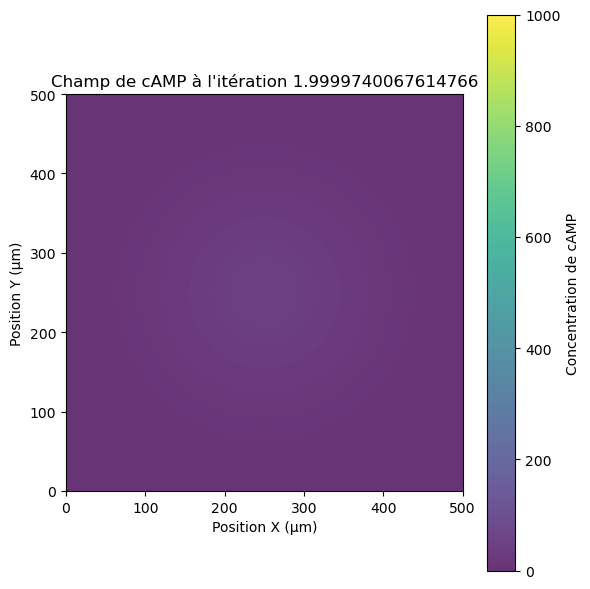

KeyboardInterrupt: 

In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

### Importation des bibliothèques ###
import math
import os
import sys
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import trackpy as tp
import functions_analyze as lib
from scipy.signal import find_peaks

# Définition de l'appareil (CPU ou GPU) pour les opérations PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Appareil pour les opérations torch :", device)

def force_field_inbox(coordinates_diff, distances, Req, R0, Frep, Fadh,
                      coeff_a=None, coeff_rep=None):
    """
    Calcule le champ de forces entre les cellules en prenant en compte les forces
    de répulsion et d'adhésion, selon les distances entre les cellules.
    """
    Rlim = 1e-6  # Limite inférieure pour éviter la division par zéro
    R = torch.norm(coordinates_diff, dim=2)
    R = torch.where(R > Rlim, R, Rlim)

    force = torch.zeros_like(R)
    mask_adh = (R < R0) & (R > Req)
    force[mask_adh] = -((Fadh / (R0 - Req)) * R[mask_adh] - Fadh * Req / (R0 - Req))

    mask_rep = R <= Req
    force[mask_rep] = -Frep * coeff_rep * (1 / Req - 1 / R[mask_rep])

    normalized_diff = torch.nn.functional.normalize(coordinates_diff, dim=2)
    force_field = torch.sum(force[:, :, None] * normalized_diff, axis=1)

    return force_field

def plot_environment(cells, camp_field, space_size, axis, iteration=None):
    """
    Trace l'environnement de simulation, y compris les positions des cellules et
    la concentration du champ de cAMP.
    """
    axis.set_xlim(0, space_size)
    axis.set_ylim(0, space_size)

    extent = [0, space_size, 0, space_size]
    cmap = plt.cm.viridis
    im = axis.imshow(camp_field.signal.cpu().numpy().T, origin='lower', extent=extent, cmap=cmap, alpha=0.5)

    positions = torch.stack([cell.position for cell in cells]).cpu()
    x = positions[:, 0].numpy()
    y = positions[:, 1].numpy()

    colors = ['blue' if cell.pop == 'Population 1' else 'red' for cell in cells]

    axis.scatter(x, y, s=5, color=colors, alpha=0.5, edgecolors='k')

    axis.set_xlabel('Position X (micromètres)')
    axis.set_ylabel('Position Y (micromètres)')
    axis.set_title(f'Temps: {iteration * DELTA_T.item():.2f} min')

def plot_camp_field(camp_field, space_size, iteration, vmin=0, vmax=10000.0):
    """
    Trace le champ de cAMP à une itération donnée avec une échelle de couleur fixe de 0 à 15.
    """
    extent = [0, space_size, 0, space_size]
    plt.figure(figsize=(6,6))
    
    # Utilisation de vmin et vmax pour fixer l'échelle de la barre de couleur
    im = plt.imshow(camp_field.signal.cpu().numpy().T, origin='lower', extent=extent, cmap='viridis', alpha=0.8, vmin=vmin, vmax=vmax)
    
    plt.title(f'Champ de cAMP à l\'itération {iteration}')
    plt.xlabel('Position X (μm)')
    plt.ylabel('Position Y (μm)')
    
    # Ajouter une barre de couleur avec une échelle fixe
    cbar = plt.colorbar(im, label='Concentration de cAMP')
    
    plt.tight_layout()
    plt.show()
    plt.close()

def plot_function(pas, Req, R0, Frep, Fadh, a, coeff_rep):
    """
    Trace les fonctions de force de répulsion et d'adhésion en fonction de la distance.
    """
    fig, axis = plt.subplots(figsize=(6, 6))
    plt.xlim(0, R0)
    plt.ylim(-Frep, Fadh)

    R_rep = np.arange(pas, Req, pas)
    force_rep = Frep * coeff_rep * (1 / Req - 1 / R_rep)
    axis.plot(R_rep, force_rep, label='Répulsion')

    R_adh = np.arange(Req, R0, pas)
    force_adh = (Fadh / (R0 - Req)) * (R_adh - Req)
    axis.plot(R_adh, force_adh, label='Adhésion')

    plt.xlabel('Distance')
    plt.ylabel('Force')
    plt.legend()
    plt.show()

def autovel(dX, n, tau, noise, dt, persistence):
    """
    Calcule la nouvelle direction des cellules basée sur leur déplacement,
    leur direction précédente, le bruit, le temps caractéristique tau, et la persistance.

    Paramètres:
    - dX: Tensor de déplacement des cellules (N x 2)
    - n: Tensor des directions précédentes des cellules (N x 2)
    - tau: Tensor des tau pour chaque cellule (N)
    - noise: Tensor du bruit pour chaque cellule (N)
    - dt: Tenseur scalaire du pas de temps
    - persistence: Tensor de persistance pour chaque cellule (N)

    Retourne:
    - new_direction: Tensor des nouvelles directions (N x 2)
    """
    dX_norm = torch.nn.functional.normalize(dX, dim=1) * 0.9999999

    # Si persistence est un tenseur, on traite les cas où elle est égale à 1
    persistence = torch.where(persistence == 1, torch.tensor(0.9999999, device=device), persistence)

    theta = torch.atan2(dX_norm[:, 1], dX_norm[:, 0])
    dtheta = torch.arcsin(n[:, 0] * dX_norm[:, 1] - n[:, 1] * dX_norm[:, 0]) * dt / tau

    # Assurez-vous que dt est un tenseur scalaire
    rnd = (2 * math.pi * (torch.rand(len(dX), device=device) - 0.5)) * noise * torch.sqrt(dt)

    theta_update = theta + dtheta + rnd
    new_direction = torch.stack((torch.cos(theta_update), torch.sin(theta_update)), dim=1)
    return new_direction

def compute_local_gradient(signal_grid, positions, grid_resolution):
    """
    Calcule le gradient du cAMP aux positions données.
    """
    grad_x = (torch.roll(signal_grid, shifts=-1, dims=0) - torch.roll(signal_grid, shifts=1, dims=0)) / (2 * grid_resolution)
    grad_y = (torch.roll(signal_grid, shifts=-1, dims=1) - torch.roll(signal_grid, shifts=1, dims=1)) / (2 * grid_resolution)

    x_indices = (positions[:, 0] / grid_resolution).long() % signal_grid.shape[0]
    y_indices = (positions[:, 1] / grid_resolution).long() % signal_grid.shape[1]

    cell_grad_x = grad_x[x_indices, y_indices]
    cell_grad_y = grad_y[x_indices, y_indices]

    gradients = torch.stack((cell_grad_x, cell_grad_y), dim=1)
    return gradients

class CellAgent:
    def __init__(self, id, pop, position, velocity,
                 velocity_magnitude, persistence, space_size,
                 tau, noise, cell_params, sensitivity_cAMP_threshold):
        """
        Classe représentant une cellule individuelle dans la simulation.
        """
        self.id = id
        self.pop = pop
        self.position_init = position.clone().to(device)
        self.position = position.clone().to(device)
        self.velocity = velocity.clone().to(device)
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.space_size = space_size
        self.tau = tau
        self.noise = noise
        self.direction = torch.nn.functional.normalize(velocity, p=2, dim=0)
        self.A = torch.tensor(0.5, device=device)
        self.R = torch.tensor(0.5, device=device)
        self.cell_params = cell_params
        self.D = cell_params['D']
        self.a0 = cell_params['a0']
        self.af = cell_params['af']
        self.sensitivity_threshold = sensitivity_cAMP_threshold

class Population:
    def __init__(self, num_cells, space_size, velocity_magnitude,
                 persistence, min_distance, pop_tag, ecart_type,
                 tau, noise, cell_params, sensitivity_cAMP_threshold):
        """
        Classe représentant une population de cellules.
        """
        self.num_cells = num_cells
        self.space_size = space_size
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.min_distance = min_distance
        self.pop_tag = pop_tag
        self.ecart_type = ecart_type
        self.tau = tau
        self.noise = noise
        self.cell_params = cell_params
        self.sensitivity_cAMP_threshold = sensitivity_cAMP_threshold
        self.cells = []
        self.initialize_cells()

    def initialize_cells(self):
        global cell_id_counter
        positions = torch.rand((self.num_cells, 2), device=device) * self.space_size
        directions = torch.nn.functional.normalize(torch.empty_like(positions).uniform_(-1, 1), dim=1)
        vitesses_gaussiennes = torch.normal(mean=self.velocity_magnitude, std=self.ecart_type, size=(self.num_cells,), device=device)

        for i in range(self.num_cells):
            velocity = directions[i] * vitesses_gaussiennes[i]
            self.cells.append(CellAgent(cell_id_counter, self.pop_tag, positions[i], velocity,
                                        vitesses_gaussiennes[i], self.persistence, self.space_size,
                                        self.tau, self.noise, self.cell_params, self.sensitivity_cAMP_threshold))
            cell_id_counter += 1

class Surface:
    def get_friction(self, position):
        friction = torch.empty(1, device=device).uniform_(0, 0.2)
        return friction.item()

class cAMP:
    def __init__(self, space_size, cell_params, initial_condition=None):
        """
        Classe représentant le champ de concentration du cAMP dans l'espace.

        Résout l'équation de diffusion-dégradation-production du cAMP.
        """
        self.space_size = space_size
        self.grid_resolution = cell_params['grid_resolution']
        self.grid_size = int(space_size / self.grid_resolution)
        self.D_cAMP = cell_params['D_cAMP']  # Coefficient de diffusion
        self.aPDE = cell_params['aPDE']      # Taux de dégradation
        self.a0 = cell_params['a0']          # Production basale de cAMP
        self.dx = self.grid_resolution       # Pas spatial
        self.dt = DELTA_T                    # Pas de temps de la simulation

        # Création de la grille de coordonnées
        x = torch.linspace(0, space_size, self.grid_size, device=device)
        y = torch.linspace(0, space_size, self.grid_size, device=device)
        self.X, self.Y = torch.meshgrid(x, y, indexing='ij')

        # Initialisation de la grille de concentration du cAMP
        if initial_condition is None:
            # Par défaut, concentration nulle partout
            self.signal = torch.zeros((self.grid_size, self.grid_size), device=device)
        else:
            # Si une fonction ou un tableau est fourni pour l'état initial
            if callable(initial_condition):
                # Utiliser la fonction pour définir la concentration initiale
                self.signal = initial_condition(self.X, self.Y)
            elif isinstance(initial_condition, torch.Tensor):
                # Vérifier que la taille correspond
                if initial_condition.shape == (self.grid_size, self.grid_size):
                    self.signal = initial_condition.to(device)
                else:
                    raise ValueError("La forme de initial_condition ne correspond pas à la grille.")
            else:
                # Supposer que c'est une valeur scalaire
                self.signal = torch.full((self.grid_size, self.grid_size), initial_condition, device=device)


    def compute_laplacian(self, S):
        laplacian_S = (
            torch.roll(S, shifts=1, dims=0) + torch.roll(S, shifts=-1, dims=0) +
            torch.roll(S, shifts=1, dims=1) + torch.roll(S, shifts=-1, dims=1) -
            4 * S
        ) / self.dx ** 2
        return laplacian_S

    def update(self, cells):
        """
        Met à jour la concentration du cAMP en fonction de la production par les cellules,
        de la diffusion et de la dégradation.
        """
        if cells:  # Si la liste des cellules n'est pas vide
            # Production par les cellules
            cell_positions = torch.stack([cell.position for cell in cells])
            cell_As = torch.stack([cell.A for cell in cells])
            cell_a0s = torch.tensor([cell.a0 for cell in cells], device=device)
            cell_Ds = torch.tensor([cell.D for cell in cells], device=device)
            cell_afs = torch.tensor([cell.af for cell in cells], device=device)

            x_indices = (cell_positions[:, 0] / self.grid_resolution).long() % self.grid_size
            y_indices = (cell_positions[:, 1] / self.grid_resolution).long() % self.grid_size
            indices = x_indices * self.grid_size + y_indices

            A_grid = torch.zeros(self.grid_size * self.grid_size, device=device)

            # Ajout de la production basale de cAMP par toutes les cellules
            A_grid.index_add_(0, indices, cell_a0s)

            # Ajout de la production par les cellules activées
            active_cells = cell_As > cell_afs
            A_grid.index_add_(0, indices[active_cells], cell_Ds[active_cells])

            A_grid = A_grid.view(self.grid_size, self.grid_size)

            # Calcul du laplacien pour la diffusion
            laplacian_S = self.compute_laplacian(self.signal)

            # Mise à jour du signal cAMP avec la diffusion, la dégradation et la production
            self.signal += self.dt * (self.D_cAMP * laplacian_S - self.aPDE * self.signal + A_grid)
            self.signal = torch.clamp(self.signal, min=0)
        else:
            # Cas sans cellules : seulement diffusion et dégradation
            laplacian_S = self.compute_laplacian(self.signal)

            # Mise à jour du signal cAMP uniquement avec la diffusion et la dégradation
            self.signal += self.dt * (self.D_cAMP * laplacian_S - self.aPDE * self.signal)
            self.signal = torch.clamp(self.signal, min=0)


    def get_signal_at_positions(self, positions):
        x_indices = (positions[:, 0] / self.grid_resolution).long() % self.grid_size
        y_indices = (positions[:, 1] / self.grid_resolution).long() % self.grid_size
        return self.signal[x_indices, y_indices]

# Paramètres de contrôle
INCLUDE_CELLS = False          # Mettre à False pour exclure les cellules de la simulation
PLOT = False

# In[Simulation parameters]
R_SENSING_GRAD = 10.0  # Distance en μm sur laquelle la cellule peut sentir le gradient

# Paramètres des cellules pour le modèle de FitzHugh-Nagumo
cell_params = {
    'c0': 1.0,        # Terme constant dans l'équation de R
    'a': 5.0,         # Couplage entre le signal et l'activateur A
    'gamma': 0.1,     # Taux de relaxation du répresseur R
    'Kd': 0.5,        # Ajuster Kd pour définir la sensibilité au cAMP
    'sigma': 0.05,    # Intensité du bruit pour A
    'epsilon': 0.2,   # Ajuster le taux de relaxation de R
    'D': 150.0,         # Taux de production de cAMP par les cellules activées (réduit)
    'a0': 0.0,        # Production basale de cAMP
    'af': 0.1,        # Seuil d'activation pour la production de cAMP
    'noise': True,
    'D_cAMP': 2400.0,   # Coefficient de diffusion du cAMP μm2/min (40 μm2/s)
    'aPDE': 1.0,      # Taux de dégradation du cAMP
    'grid_resolution': 0.5,  # Taille des cellules de la grille (μm)
    'chemotaxis_sensitivity' : 0.5 # Paramètre de chimiotaxie (sensibilité au gradient de cAMP)
    #C'est le % de suivi de la direction en cours, avec alignment avec le grad cAMP alentours. 
}

# Paramètre de l'espace
SPACE_SIZE = 500  # Taille de l'espace de simulation en micromètres
# Paramètres temporels
TIME_SIMU = 1000  # Temps total de simulation en minutes
# DELTA_T est maintenant un tenseur
DELTA_T_value = (cell_params['grid_resolution']**2)/(4*cell_params['D_cAMP']) # Pas de temps de la simulation en minutes (réduit pour stabilité)
#D'après le critère de stabilité de Couran_Friedrichs_Lewy (CFL) delta_T <= ((Δx)**2)/(4*D_cAMP)) 
DELTA_T = torch.tensor(DELTA_T_value, device=device)

PLOT_INTERVAL = int(1/DELTA_T)  # Intervalle pour la sauvegarde des images

# Definition des cellules et populations
if INCLUDE_CELLS:
    MU = 1  # Mobilité (μm / min·kg⁻¹)
    F_REP = 40  # Intensité de la force de répulsion
    F_ADH = 7  # Intensité de la force d'adhésion
    R_EQ = 1.1  # Rayon d'équilibre (μm)
    R_0 = 1.6  # Rayon maximal d'interaction (μm)
    MIN_DISTANCE_INIT = R_EQ  # Distance minimale entre cellules à l'initialisation
    COEFF_CARRE = 50  # Coefficient quadratique (non utilisé ici)
    COEFF_REP = 0.5  # Coefficient pour ajuster la force de répulsion
    # Trace la fonction de force pour visualiser les forces de répulsion et d'adhésion
    plot_function(pas=0.01, Req=R_EQ, R0=R_0, Frep=F_REP,
                Fadh=F_ADH, a=COEFF_CARRE, coeff_rep=COEFF_REP)

    # Facteur de fluctuation pour la vitesse
    FLUCTUATION_FACTOR = 3

    # Définition des cellules
    PACKING_FRACTION = 0.04  # Fraction de l'espace occupée par les cellules
    # Calcul du nombre de cellules en fonction de la fraction de remplissage
    N_CELLS = int((PACKING_FRACTION * SPACE_SIZE ** 2) /
                (math.pi * ((R_EQ / 2) ** 2)))  # Nombre total de cellules
    print(N_CELLS, "cells")

    # Paramètres de la Population 1
    velocity_magnitude_pop1 = 0 * 3  # Vitesse moyenne des cellules de la population 1 (μm/min)
    ECART_TYPE_POP1 = 0.3  # Écart-type de la vitesse pour la population 1
    NOISE_POP_1 = 0 * 8  # Intensité du bruit pour la population 1
    TAU_POP_1 = 5  # Temps caractéristique pour la population 1
    PERSISTENCE_POP1 = 0  # Persistance du mouvement pour la population 1
    SENSITIVITY_cAMP_THRESHOLD_POP1 = 0.1

    # Paramètres de la Population 2
    velocity_magnitude_pop2 = 0 * 8  # Vitesse moyenne des cellules de la population 2 (μm/min)
    ECART_TYPE_POP2 = 0.5  # Écart-type de la vitesse pour la population 2
    NOISE_POP_2 = 0 * 5  # Intensité du bruit pour la population 2
    TAU_POP_2 = 5  # Temps caractéristique pour la population 2
    PERSISTENCE_POP2 = 0  # Persistance du mouvement pour la population 2
    SENSITIVITY_cAMP_THRESHOLD_POP2 = 0.1

    # Définition des populations
    cell_id_counter = 0  # Initialisation du compteur d'ID des cellules
    population1 = Population(num_cells=int(N_CELLS / 2), space_size=SPACE_SIZE,
                            velocity_magnitude=velocity_magnitude_pop1,
                            persistence=PERSISTENCE_POP1, ecart_type=ECART_TYPE_POP1,
                            min_distance=MIN_DISTANCE_INIT, pop_tag="Population 1",
                            tau=TAU_POP_1, noise=NOISE_POP_1, cell_params=cell_params,
                            sensitivity_cAMP_threshold=SENSITIVITY_cAMP_THRESHOLD_POP1)

    population2 = Population(num_cells=int(N_CELLS / 2), space_size=SPACE_SIZE,
                            velocity_magnitude=velocity_magnitude_pop2,
                            persistence=PERSISTENCE_POP2, ecart_type=ECART_TYPE_POP2,
                            min_distance=MIN_DISTANCE_INIT, pop_tag="Population 2",
                            tau=TAU_POP_2, noise=NOISE_POP_2, cell_params=cell_params,
                            sensitivity_cAMP_threshold=SENSITIVITY_cAMP_THRESHOLD_POP2)

    # Combinaison des cellules des deux populations
    cells = population1.cells + population2.cells

    # Initialisations des positions et vitesses des cellules.
    positions = torch.stack([cell.position_init for cell in cells])
    V0 = torch.tensor([cell.velocity_magnitude for cell in cells], device=device).unsqueeze(1)
    direction = torch.stack([cell.direction for cell in cells])
    positions = torch.stack([cell.position for cell in cells])
    
else:
    cells = []  # Liste vide si on n'inclut pas les cellules

# In[Initialisation du système]
##### no gradient condition initial #######
def no_gradient_initial_condition(X, Y):
    return torch.full_like(X, 0.5, device=device)

##### Fonction pour créer un gradient de concentration de 0 en haut à 100 en bas ##### 
def gradient_haut_bas_initial_condition(X, Y):
    return (Y / SPACE_SIZE) * 100.0  # Y varie de 0 à SPACE_SIZE

##### Gradient linéaire max au centre min en hau et bas #######
def gradient_max_centre_min_haut_bas_initial_condition(X, Y):
    max_concentration = 25.0  # Valeur maximale de la concentration au milieu
    return (max_concentration * (1 - ((2 * (Y - SPACE_SIZE / 2) / SPACE_SIZE) ** 2))).to(device)

##### Gradient linéaire radial partant du centre #######
def gradient_radial_initial_condition(X, Y):
    X_c = SPACE_SIZE / 2
    Y_c = SPACE_SIZE / 2
    R_max = math.sqrt(2) * (SPACE_SIZE / 2)  # Distance maximale au coin de l'espace
    R = torch.sqrt((X - X_c) ** 2 + (Y - Y_c) ** 2)
    max_concentration = 10.0
    signal = max_concentration * (1 - R / R_max)
    signal = torch.clamp(signal, min=0.0)  # Éviter les valeurs négatives
    return signal.to(device)

##### Tâche circulaire au centre de l'espace #######
def gradient_initial_condition(X, Y, center_value=10000.0, radius=25.0):
    """
    Crée une tache circulaire de cAMP au centre de la grille avec une concentration maximale au centre 
    et nulle en dehors d'un certain rayon.

    Paramètres:
    - X, Y: Les grilles de coordonnées en 2D.
    - center_value: Valeur maximale de la concentration de cAMP au centre de la tache.
    - radius: Rayon de la tache de cAMP (en unités de distance de la grille).

    Retourne:
    - signal: Grille de concentration de cAMP avec une tache circulaire au centre.
    """
    # Centre de la grille
    X_c = X.mean().item()
    Y_c = Y.mean().item()

    # Calcul de la distance de chaque point au centre
    distance_from_center = torch.sqrt((X - X_c) ** 2 + (Y - Y_c) ** 2)
    
    # Créer un masque où la distance est inférieure au rayon de la tache
    mask = distance_from_center <= radius

    # Initialiser le signal à zéro
    signal = torch.zeros_like(X)

    # Appliquer la valeur de cAMP dans la région de la tache
    signal[mask] = center_value

    return signal

# Initialisation de surface
surface = Surface()  # Création d'une instance de Surface (non utilisée ici)

# Initialisation de la grille de cAMP avec le gradient initial
INITIAL_AMPc = 1 # None
camp_field = cAMP(SPACE_SIZE, cell_params,
                  initial_condition=gradient_initial_condition)
if INITIAL_AMPc is not None:
    plot_camp_field(camp_field, space_size=SPACE_SIZE, iteration=0)

# Plot de l'état initial
if PLOT:
    PATH = f'../simulations_images/GPU_v1{velocity_magnitude_pop1}v2{velocity_magnitude_pop2}a{COEFF_CARRE}coefrep{COEFF_REP}fadh{F_ADH}frep{F_REP}/'
    if not os.path.exists(PATH):
        os.makedirs(PATH)
    else:
        print("ATTENTION : LE DOSSIER EXISTE DÉJÀ !")
        sys.exit(0)
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_environment(cells, camp_field, SPACE_SIZE, axis=ax, iteration=0)
    plt.savefig(f'{PATH}image_0.png', bbox_inches='tight', dpi=300, pad_inches=0)
    plt.close()

# In[Simulation]
time = 0
iteration = 1
MAX_DISTANCE = np.sqrt(2 * (SPACE_SIZE / 2) ** 2)
data_list = []
while time < TIME_SIMU:
    if INCLUDE_CELLS : 
        # Récupération des attributs des cellules
        cell_positions = torch.stack([cell.position for cell in cells])
        cell_directions = torch.stack([cell.direction for cell in cells])
        cell_As = torch.stack([cell.A for cell in cells])
        cell_Rs = torch.stack([cell.R for cell in cells])
        cell_params_a = torch.tensor([cell.cell_params['a'] for cell in cells], device=device)
        cell_params_Kd = torch.tensor([cell.cell_params['Kd'] for cell in cells], device=device)
        cell_params_gamma = torch.tensor([cell.cell_params['gamma'] for cell in cells], device=device)
        cell_params_c0 = torch.tensor([cell.cell_params['c0'] for cell in cells], device=device)
        cell_params_epsilon = torch.tensor([cell.cell_params['epsilon'] for cell in cells], device=device)
        cell_params_sigma = torch.tensor([cell.cell_params['sigma'] for cell in cells], device=device)
        cell_afs = torch.tensor([cell.af for cell in cells], device=device)
        cell_pops = [cell.pop for cell in cells]

        # Extraction de tau, noise et persistence
        taus = torch.tensor([cell.tau for cell in cells], device=device)
        noises = torch.tensor([cell.noise for cell in cells], device=device)
        persistences = torch.tensor([cell.persistence for cell in cells], device=device)

        # Obtenir la concentration de cAMP aux positions des cellules
        signal_values = camp_field.get_signal_at_positions(cell_positions)

        # Mise à jour des états A et R des cellules
        I_S = cell_params_a * torch.log1p(signal_values / cell_params_Kd)
        dA = (cell_As - (cell_As ** 3) / 3 - cell_Rs + I_S) * DELTA_T
        dA += cell_params_sigma * torch.sqrt(DELTA_T) * torch.randn_like(cell_As, device=device)
        cell_As += dA
        dR = (cell_As - cell_params_gamma * cell_Rs + cell_params_c0) * cell_params_epsilon * DELTA_T
        cell_Rs += dR

        # Mise à jour des attributs des cellules
        for i, cell in enumerate(cells):
            cell.A = cell_As[i]
            cell.R = cell_Rs[i]

    # Mise à jour de la grille de cAMP
    camp_field.update(cells)
    if iteration % PLOT_INTERVAL == 0:
        plot_camp_field(camp_field, space_size=SPACE_SIZE, iteration=time, vmin=0.0, vmax=1000)

    if INCLUDE_CELLS : 
        # Calcul du gradient du cAMP pour chaque cellule et ajustement de la direction
        gradients = compute_local_gradient(camp_field.signal, cell_positions, camp_field.grid_resolution)
        local_camp_concentrations = signal_values
        chemotaxis_mask = local_camp_concentrations >= torch.tensor([cell.sensitivity_threshold for cell in cells], device=device)

        # Normalisation des gradients
        gradients_norm = torch.norm(gradients, dim=1, keepdim=True)
        gradients_norm[gradients_norm == 0] = 1
        gradients_normalized = gradients / gradients_norm

        # Mise à jour des directions en tenant compte de la chimiotaxie
        chemotaxis_sensitivity = cell_params['chemotaxis_sensitivity']
        cell_directions = torch.where(
            chemotaxis_mask.unsqueeze(1),
            (1 - chemotaxis_sensitivity) * cell_directions + chemotaxis_sensitivity * gradients_normalized,
            cell_directions
        )
        cell_directions = torch.nn.functional.normalize(cell_directions, dim=1)

        # Calcul des différences de coordonnées entre les cellules (pour les forces)
        coordinates_diff = ((cell_positions[:, None, :] - cell_positions[None, :, :]))
        coordinates_diff = torch.remainder(coordinates_diff - (SPACE_SIZE / 2), SPACE_SIZE) - (SPACE_SIZE / 2)
        distances = torch.norm(coordinates_diff, dim=2)

        # Calcul du champ de forces entre les cellules
        force_field = force_field_inbox(coordinates_diff, distances, Req=R_EQ,
                                        R0=R_0, Frep=F_REP, Fadh=F_ADH,
                                        coeff_a=COEFF_CARRE, coeff_rep=COEFF_REP)

        # Calcul du déplacement des cellules
        V0 = torch.tensor([cell.velocity_magnitude for cell in cells], device=device).unsqueeze(1)
        fluctuations = (torch.rand(V0.shape, device=device) - 0.5) * FLUCTUATION_FACTOR
        displacement = MU * force_field * DELTA_T + (V0 + fluctuations) * cell_directions * DELTA_T

        # Mise à jour des positions des cellules
        cell_positions += displacement
        cell_positions = torch.remainder(cell_positions, SPACE_SIZE)

        # Mise à jour des directions des cellules
        cell_directions = autovel(displacement, cell_directions, tau=taus, noise=noises, dt=DELTA_T, persistence=persistences)

        # Mise à jour des attributs des cellules
        for i, cell in enumerate(cells):
            cell.position = cell_positions[i]
            cell.direction = cell_directions[i]

            # Enregistrement des informations de la cellule pour l'analyse
            data_list.append({
                'frame': time,
                'particle': cell.id,
                'pop_tag': cell.pop,
                'x': cell.position[0].item(),
                'y': cell.position[1].item(),
                'dir_x': cell.direction[0].item(),
                'dir_y': cell.direction[1].item()
            })

    # Modification du bloc PLOT
    if PLOT:
        marker_radius = 1.1
        marker_size = (np.pi) * marker_radius ** 2
        if iteration % PLOT_INTERVAL == 0:
            # Créer une figure avec 4 sous-graphes en ligne
            fig, axes = plt.subplots(1, 4, figsize=(24, 6))

            # Graphique 1 : Environnement de simulation
            plot_environment(cells, camp_field, SPACE_SIZE, axis=axes[0], iteration=iteration)

            # Graphique 2 : Champ de cAMP
            extent = [0, SPACE_SIZE, 0, SPACE_SIZE]
            im1 = axes[1].imshow(camp_field.signal.cpu().numpy().T, origin='lower', extent=extent, cmap='viridis', alpha=0.8)
            axes[1].set_title(f'Champ de cAMP à l\'itération {iteration}')
            axes[1].set_xlabel('Position X (μm)')
            axes[1].set_ylabel('Position Y (μm)')
            fig.colorbar(im1, ax=axes[1], label='Concentration de cAMP')

            # Création des grilles pour A et R avec conditions périodiques
            grid_size = camp_field.grid_size
            A_grid = torch.zeros((grid_size, grid_size), device=device)
            R_grid = torch.zeros((grid_size, grid_size), device=device)
            cell_counts = torch.zeros((grid_size, grid_size), device=device)

            for cell in cells:
                x_idx = int(cell.position[0].item() / camp_field.grid_resolution) % grid_size
                y_idx = int(cell.position[1].item() / camp_field.grid_resolution) % grid_size
                A_grid[x_idx, y_idx] += cell.A
                R_grid[x_idx, y_idx] += cell.R
                cell_counts[x_idx, y_idx] += 1

            # Éviter la division par zéro
            cell_counts_nonzero = cell_counts.clone()
            cell_counts_nonzero[cell_counts_nonzero == 0] = 1

            A_grid_avg = A_grid / cell_counts_nonzero
            R_grid_avg = R_grid / cell_counts_nonzero

            # Graphique 3 : Concentration de A
            im2 = axes[2].imshow(A_grid_avg.cpu().numpy().T, origin='lower', extent=extent, cmap='viridis', alpha=0.8)
            axes[2].set_title(f'Concentration de A à l\'itération {iteration}')
            axes[2].set_xlabel('Position X (μm)')
            axes[2].set_ylabel('Position Y (μm)')
            fig.colorbar(im2, ax=axes[2], label='Concentration de A')

            # Graphique 4 : Concentration de R
            im3 = axes[3].imshow(R_grid_avg.cpu().numpy().T, origin='lower', extent=extent, cmap='viridis', alpha=0.8)
            axes[3].set_title(f'Concentration de R à l\'itération {iteration}')
            axes[3].set_xlabel('Position X (μm)')
            axes[3].set_ylabel('Position Y (μm)')
            fig.colorbar(im3, ax=axes[3], label='Concentration de R')

            # Sauvegarder la figure
            plt.tight_layout()
            plt.savefig(f'{PATH}combined_{iteration}.png', bbox_inches='tight', dpi=300, pad_inches=0)
            plt.close()
    # Mise à jour du temps et de l'itération
    time += DELTA_T.item()
    iteration += 1
